## Import Necessary Packages

In [1]:
# @title Imports and setup

# from google.colab import files

import distutils.util
import os
import subprocess

if subprocess.run("nvidia-smi").returncode:
    raise RuntimeError(
        "Cannot communicate with GPU. "
        "Make sure you are using a GPU Colab runtime. "
        "Go to the Runtime menu and select Choose runtime type."
    )

# Add an ICD config so that glvnd can pick up the Nvidia EGL driver.
# This is usually installed as part of an Nvidia driver package, but the Colab
# kernel doesn't install its driver via APT, and as a result the ICD is missing.
# (https://github.com/NVIDIA/libglvnd/blob/master/src/EGL/icd_enumeration.md)
NVIDIA_ICD_CONFIG_PATH = "/usr/share/glvnd/egl_vendor.d/10_nvidia.json"
if not os.path.exists(NVIDIA_ICD_CONFIG_PATH):
    with open(NVIDIA_ICD_CONFIG_PATH, "w") as f:
        f.write(
            """{
    "file_format_version" : "1.0.0",
    "ICD" : {
        "library_path" : "libEGL_nvidia.so.0"
    }
}
"""
        )

# Configure MuJoCo to use the EGL rendering backend (requires GPU)
print("Setting environment variable to use GPU rendering:")
%env MUJOCO_GL=egl

try:
    print("Checking that the installation succeeded:")
    import mujoco

    mujoco.MjModel.from_xml_string("<mujoco/>")
except Exception as e:
    raise e from RuntimeError(
        "Something went wrong during installation. Check the shell output above "
        "for more information.\n"
        "If using a hosted Colab runtime, make sure you enable GPU acceleration "
        'by going to the Runtime menu and selecting "Choose runtime type".'
    )

print("Installation successful.")

# Tell XLA to use Triton GEMM, this improves steps/sec by ~30% on some GPUs
xla_flags = os.environ.get("XLA_FLAGS", "")
xla_flags += " --xla_gpu_triton_gemm_any=True"
os.environ["XLA_FLAGS"] = xla_flags

# @title Import packages for plotting and creating graphics
import time
import itertools
import numpy as np
from typing import Callable, NamedTuple, Optional, Union, List

# Graphics and plotting.
print("Installing mediapy:")
!command -v ffmpeg >/dev/null || (apt update && apt install -y ffmpeg)
!pip install -q mediapy
import mediapy as media
import matplotlib.pyplot as plt

# More legible printing from numpy.
np.set_printoptions(precision=3, suppress=True, linewidth=100)

# @title Import MuJoCo, MJX, and Brax
from datetime import datetime
from etils import epath
import functools
from IPython.display import HTML
from typing import Any, Dict, Sequence, Tuple, Union
import os
from ml_collections import config_dict


import jax
from jax import numpy as jp
import numpy as np
from flax.training import orbax_utils
from flax import struct
from matplotlib import pyplot as plt
import mediapy as media
from orbax import checkpoint as ocp

import mujoco
from mujoco import mjx

from brax import base
from brax import envs
from brax import math
from brax.base import Base, Motion, Transform
from brax.base import State as PipelineState
from brax.envs.base import Env, PipelineEnv, State
from brax.mjx.base import State as MjxState
from brax.training.agents.ppo import train as ppo
from brax.training.agents.ppo import networks as ppo_networks
from brax.io import html, mjcf, model

Sat Nov 30 23:15:09 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 555.42.06              Driver Version: 555.42.06      CUDA Version: 12.5     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4090        Off |   00000000:01:00.0 Off |                  Off |
|  0%   42C    P5             59W /  450W |    5075MiB /  24564MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## Training Setup

In [2]:
from mppi_rl.dial_mpc.dial_mpc.envs.unitree_go2_env import UnitreeGo2Env
from mppi_rl.dial_mpc.dial_mpc.envs.unitree_go2_env import UnitreeGo2EnvConfig
from mppi_rl.dial_mpc.dial_mpc.utils.function_utils import (
    global_to_body_velocity,
    get_foot_step,
)
import jax.numpy as jnp
from dial_mpc.utils.io_utils import get_model_path
from brax.base import System
from mppi_rl.brax_rl.brax_env import UnitreeGo2EnvRL, UnitreeH1EnvRL

In [33]:
class UnitreeGo2EnvRL(UnitreeGo2Env):
    def __init__(self, config: UnitreeGo2EnvConfig):
        super().__init__(config)

        lower_leg_body = [
            "FL_calf",
            "FR_calf",
            "RL_calf",
            "RR_calf",
        ]
        lower_leg_body_id = [
            mujoco.mj_name2id(self.sys.mj_model, mujoco.mjtObj.mjOBJ_BODY.value, l)
            for l in lower_leg_body
        ]
        assert not any(id_ == -1 for id_ in lower_leg_body_id), "Body not found."
        self._lower_leg_body_id = np.array(lower_leg_body_id)

    def make_system(self, config: UnitreeGo2EnvConfig) -> System:
        model_path = get_model_path("unitree_go2", "mjx_scene_position.xml")
        sys = mjcf.load(model_path)
        sys = sys.tree_replace({"opt.timestep": config.timestep})
        # sys = sys.replace(
        #     dof_damping=sys.dof_damping.at[6:].set(0.5239),
        #     actuator_gainprm=sys.actuator_gainprm.at[:, 0].set(35.0),
        #     actuator_biasprm=sys.actuator_biasprm.at[:, 1].set(-35.0),
        # )
        return sys

    def reset(self, rng: jax.Array) -> State:  # pytype: disable=signature-mismatch
        rng, key = jax.random.split(rng)

        pipeline_state = self.pipeline_init(self._init_q, jnp.zeros(self._nv))

        state_info = {
            "rng": rng,
            "pos_tar": jnp.array([0.282, 0.0, 0.3]),
            "vel_tar": jnp.array([0.0, 0.0, 0.0]),
            "ang_vel_tar": jnp.array([0.0, 0.0, 0.0]),
            "yaw_tar": 0.0,
            "step": 0,
            "z_feet": jnp.zeros(4),
            "z_feet_tar": jnp.zeros(4),
            "randomize_target": self._config.randomize_tasks,
            "last_contact": jnp.zeros(4, dtype=jnp.bool),
            "feet_air_time": jnp.zeros(4),
            "last_action": jnp.zeros(12),
        }

        obs = self._get_obs(pipeline_state, state_info)
        reward, done = jnp.zeros(2)
        metrics = {}
        state = State(pipeline_state, obs, reward, done, metrics, state_info)
        return state

    def step(self, state: State, action: jax.Array) -> State:
        rng, cmd_rng = jax.random.split(state.info["rng"], 2)

        # physics step
        joint_targets = self.act2joint(action)
        if self._config.leg_control == "position":
            ctrl = joint_targets
        # elif self._config.leg_control == "torque":
        #     ctrl = self.act2tau(action, state.pipeline_state)
        pipeline_state = self.pipeline_step(state.pipeline_state, ctrl)
        x, xd = pipeline_state.x, pipeline_state.xd

        # observation data
        obs = self._get_obs(pipeline_state, state.info)

        # switch to new target if randomize_target is True
        def dont_randomize():
            return (
                jnp.array([self._config.default_vx, self._config.default_vy, 0.0]),
                jnp.array([0.0, 0.0, self._config.default_vyaw]),
            )

        def randomize():
            return self.sample_command(cmd_rng)

        vel_tar, ang_vel_tar = jax.lax.cond(
            (state.info["randomize_target"]) & (state.info["step"] % 500 == 0),
            randomize,
            dont_randomize,
        )
        state.info["vel_tar"] = jnp.minimum(
            vel_tar * state.info["step"] * self.dt / self._config.ramp_up_time, vel_tar
        )
        state.info["ang_vel_tar"] = jnp.minimum(
            ang_vel_tar * state.info["step"] * self.dt / self._config.ramp_up_time,
            ang_vel_tar,
        )

        # reward
        # gaits reward
        z_feet = pipeline_state.site_xpos[self._feet_site_id][:, 2]
        duty_ratio, cadence, amplitude = self._gait_params[self._gait]
        phases = self._gait_phase[self._gait]
        z_feet_tar = get_foot_step(
            duty_ratio, cadence, amplitude, phases, state.info["step"] * self.dt
        )
        reward_gaits = -jnp.sum(((z_feet_tar - z_feet) / 0.05) ** 2)
        # foot contact data based on z-position
        foot_pos = pipeline_state.site_xpos[
            self._feet_site_id
        ]  # pytype: disable=attribute-error
        foot_contact_z = foot_pos[:, 2] - self._foot_radius
        contact = foot_contact_z < 1e-3  # a mm or less off the floor
        contact_filt_mm = contact | state.info["last_contact"]
        contact_filt_cm = (foot_contact_z < 3e-2) | state.info["last_contact"]
        first_contact = (state.info["feet_air_time"] > 0) * contact_filt_mm
        state.info["feet_air_time"] += self.dt
        reward_air_time = jnp.sum((state.info["feet_air_time"] - 0.1) * first_contact)
        # position reward
        pos_tar = (
            state.info["pos_tar"] + state.info["vel_tar"] * self.dt * state.info["step"]
        )
        pos = x.pos[self._torso_idx - 1]
        R = math.quat_to_3x3(x.rot[self._torso_idx - 1])
        head_vec = jnp.array([0.285, 0.0, 0.0])
        head_pos = pos + jnp.dot(R, head_vec)
        reward_pos = -jnp.sum((head_pos - pos_tar) ** 2)
        # stay upright reward
        vec_tar = jnp.array([0.0, 0.0, 1.0])
        vec = math.rotate(vec_tar, x.rot[0])
        reward_upright = -jnp.sum(jnp.square(vec - vec_tar))
        # yaw orientation reward
        yaw_tar = (
            state.info["yaw_tar"]
            + state.info["ang_vel_tar"][2] * self.dt * state.info["step"]
        )
        yaw = math.quat_to_euler(x.rot[self._torso_idx - 1])[2]
        d_yaw = yaw - yaw_tar
        reward_yaw = -jnp.square(jnp.atan2(jnp.sin(d_yaw), jnp.cos(d_yaw)))
        # stay to norminal pose reward
        # reward_pose = -jnp.sum(jnp.square(joint_targets - self._default_pose))
        # velocity reward
        vb = global_to_body_velocity(
            xd.vel[self._torso_idx - 1], x.rot[self._torso_idx - 1]
        )
        ab = global_to_body_velocity(
            xd.ang[self._torso_idx - 1] * jnp.pi / 180.0, x.rot[self._torso_idx - 1]
        )
        reward_vel = -jnp.sum((vb[:2] - state.info["vel_tar"][:2]) ** 2)
        reward_ang_vel = -jnp.sum((ab[2] - state.info["ang_vel_tar"][2]) ** 2)
        # height reward
        reward_height = -jnp.sum(
            (x.pos[self._torso_idx - 1, 2] - state.info["pos_tar"][2]) ** 2
        )
        # energy reward
        reward_energy = -jnp.sum(
            jnp.maximum(ctrl * pipeline_state.qvel[6:] / 160.0, 0.0) ** 2
        )
        # stay alive reward
        reward_alive = 1.0 - state.done

        # reward lin vel z
        reward_lin_vel_z = jnp.square(xd.vel[0, 2])

        # reward ang vel xy
        reward_ang_vel_xy = jnp.sum(jnp.square(xd.ang[0, :2]))

        # reward orientation
        up = jp.array([0.0, 0.0, 1.0])
        rot_up = math.rotate(up, x.rot[0])
        reward_orientation = jp.sum(jp.square(rot_up[:2]))

        # reward torques
        torques = pipeline_state.qfrc_actuator
        reward_torques = jp.sqrt(jp.sum(jp.square(torques))) + jp.sum(jp.abs(torques))

        # reward action rate
        reward_action_rate = jp.sum(jp.square(action - state.info["last_action"]))

        # done
        up = jnp.array([0.0, 0.0, 1.0])
        joint_angles = pipeline_state.q[7:]
        done = jnp.dot(math.rotate(up, x.rot[self._torso_idx - 1]), up) < 0
        done |= jnp.any(joint_angles < self.joint_range[:, 0])
        done |= jnp.any(joint_angles > self.joint_range[:, 1])
        done |= pipeline_state.x.pos[self._torso_idx - 1, 2] < 0.18

        # reward termination
        reward_termination = done & (state.info["step"] < 500)

        # reward foot slip
        pos = pipeline_state.site_xpos[self._feet_site_id]  # feet position
        feet_offset = pos - pipeline_state.xpos[self._lower_leg_body_id]
        # pytype: enable=attribute-error
        offset = base.Transform.create(pos=feet_offset)
        foot_indices = self._lower_leg_body_id - 1  # we got rid of the world body
        foot_vel = offset.vmap().do(pipeline_state.xd.take(foot_indices)).vel

        # Penalize large feet velocity for feet that are in contact with the ground.
        reward_foot_slip = jp.sum(
            jp.square(foot_vel[:, :2]) * contact_filt_cm.reshape((-1, 1))
        )

        # reward tracking lin vel
        local_vel = math.rotate(xd.vel[0], math.quat_inv(x.rot[0]))
        lin_vel_error = jp.sum(jp.square(state.info["vel_tar"][:2]) - local_vel[:2])
        lin_vel_reward = jp.exp(-lin_vel_error / 0.05)
        reward_tracking_lin_vel = lin_vel_reward

        # reward tracking ang vel
        base_ang_vel = math.rotate(xd.ang[0], math.quat_inv(x.rot[0]))
        ang_vel_error = jp.square(state.info["ang_vel_tar"][2] - base_ang_vel[2])
        reward_tracking_ang_vel = jp.exp(-ang_vel_error / 0.05)

        # reward
        reward = (
            reward_gaits * 0.0
            + reward_pos * 0.0
            + reward_upright * 0.0
            + reward_yaw * 0.0
            # + reward_pose * 0.0
            + reward_vel * 0.0
            + reward_ang_vel * 0.0
            + reward_height * 0.0
            + reward_energy * 0.0
            + reward_alive * 0.0
            + reward_air_time * 0.2
            + reward_lin_vel_z * -2.0
            + reward_ang_vel_xy * -0.05
            + reward_orientation * -5.0
            + reward_torques * -0.0002
            + reward_action_rate * -0.01
            + reward_termination * -10.0
            + reward_foot_slip * -0.1
            + reward_tracking_lin_vel * 1.5
            + reward_tracking_ang_vel * 0.8
        )

        reward = jp.clip(reward * self.dt, 0.0, 10000.0)

        done = done.astype(jnp.float32)
        jax.debug.print(
            f"reward, air_time: {reward_air_time}, lin_vel_z: {reward_lin_vel_z}, ang_vel_xy: {reward_ang_vel_xy}, orientation: {reward_orientation}, torques: {reward_torques}, action_rate: {reward_action_rate}, termination: {reward_termination}, foot_slip: {reward_foot_slip}, tracking_lin_vel: {reward_tracking_lin_vel}, tracking_ang_vel: {reward_tracking_ang_vel}"
        )

        # state management
        state.info["step"] += 1
        state.info["rng"] = rng
        state.info["z_feet"] = z_feet
        state.info["z_feet_tar"] = z_feet_tar
        state.info["feet_air_time"] *= ~contact_filt_mm
        state.info["last_contact"] = contact
        state.info["last_action"] = action

        state = state.replace(
            pipeline_state=pipeline_state, obs=obs, reward=reward, done=done
        )
        return state

In [4]:
def domain_randomize(sys, rng):
    """Randomizes the mjx.Model."""

    @jax.vmap
    def rand(rng):
        _, key = jax.random.split(rng, 2)
        # friction
        friction = jax.random.uniform(key, (1,), minval=0.6, maxval=1.4)
        friction = sys.geom_friction.at[:, 0].set(friction)
        # actuator
        _, key = jax.random.split(key, 2)
        gain_range = (-5, 5)
        param = (
            jax.random.uniform(key, (1,), minval=gain_range[0], maxval=gain_range[1])
            + sys.actuator_gainprm[:, 0]
        )
        gain = sys.actuator_gainprm.at[:, 0].set(param)
        bias = sys.actuator_biasprm.at[:, 1].set(-param)
        return friction, gain, bias

    friction, gain, bias = rand(rng)

    in_axes = jax.tree_util.tree_map(lambda x: None, sys)
    in_axes = in_axes.tree_replace(
        {
            "geom_friction": 0,
            "actuator_gainprm": 0,
            "actuator_biasprm": 0,
        }
    )

    sys = sys.tree_replace(
        {
            "geom_friction": friction,
            "actuator_gainprm": gain,
            "actuator_biasprm": bias,
        }
    )

    return sys, in_axes

In [115]:
# @title Barkour vb Quadruped Env

# GO2_ROOT_PATH = epath.Path('mujoco_menagerie/unitree_go2')
from functools import partial


def get_config():
    """Returns reward config for barkour quadruped environment."""

    def get_default_rewards_config():
        default_config = config_dict.ConfigDict(
            dict(
                # The coefficients for all reward terms used for training. All
                # physical quantities are in SI units, if no otherwise specified,
                # i.e. joint positions are in rad, positions are measured in meters,
                # torques in Nm, and time in seconds, and forces in Newtons.
                scales=config_dict.ConfigDict(
                    dict(
                        # Tracking rewards are computed using exp(-delta^2/sigma)
                        # sigma can be a hyperparameters to tune.
                        # Track the base x-y velocity (no z-velocity tracking.)
                        tracking_lin_vel=1.5 * 1.0,
                        # Track the angular velocity along z-axis, i.e. yaw rate.
                        tracking_ang_vel=0.8,
                        # Below are regularization terms, we roughly divide the
                        # terms to base state regularizations, joint
                        # regularizations, and other behavior regularizations.
                        # Penalize the base velocity in z direction, L2 penalty.
                        lin_vel_z=-2.0,
                        # Penalize the base roll and pitch rate. L2 penalty.
                        ang_vel_xy=-0.05,
                        # Penalize non-zero roll and pitch angles. L2 penalty.
                        orientation=-5.0,
                        # L2 regularization of joint torques, |tau|^2.
                        torques=-0.0002,
                        # Penalize the change in the action and encourage smooth
                        # actions. L2 regularization |action - last_action|^2
                        action_rate=-0.01,
                        # Encourage long swing steps.  However, it does not
                        # encourage high clearances.
                        feet_air_time=0.2,
                        # Encourage no motion at zero command, L2 regularization
                        # |q - q_default|^2.
                        stand_still=-0.5,
                        # Early termination penalty.
                        termination=-1.0,
                        # Penalizing foot slipping on the ground.
                        foot_slip=-0.1,
                    )
                ),
                # Tracking reward = exp(-error^2/sigma).
                tracking_sigma=0.25,
            )
        )
        return default_config

    default_config = config_dict.ConfigDict(
        dict(
            rewards=get_default_rewards_config(),
        )
    )

    return default_config


class UnitreeGo2EnvRL(PipelineEnv):
    """Environment for training the barkour quadruped joystick policy in MJX."""

    def __init__(
        self,
        obs_noise: float = 0.05,
        action_scale: float = 0.3,
        kick_vel: float = 0.05,
        scene_file: str = "scene_mjx.xml",
        **kwargs,
    ):
        # path = GO2_ROOT_PATH / scene_file
        # sys = mjcf.load(path.as_posix())
        # model_path = get_model_path("unitree_go2", "mjx_scene.xml")
        model_path = get_model_path("unitree_go2", "mjx_scene_position.xml")
        sys = mjcf.load(model_path)
        self._dt = 0.02  # this environment is 50 fps
        sys = sys.tree_replace({"opt.timestep": 0.02})

        # override menagerie params for smoother policy
        sys = sys.replace(
            dof_damping=sys.dof_damping.at[6:].set(0.5239),
            actuator_gainprm=sys.actuator_gainprm.at[:, 0].set(35.0),
            actuator_biasprm=sys.actuator_biasprm.at[:, 1].set(-35.0),
        )

        n_frames = kwargs.pop("n_frames", int(self._dt / sys.opt.timestep))
        super().__init__(sys, backend="mjx", n_frames=n_frames)

        self.reward_config = get_config()
        # set custom from kwargs
        for k, v in kwargs.items():
            if k.endswith("_scale"):
                self.reward_config.rewards.scales[k[:-6]] = v

        self._torso_idx = mujoco.mj_name2id(
            sys.mj_model, mujoco.mjtObj.mjOBJ_BODY.value, "torso"
        )
        self._action_scale = action_scale
        self._obs_noise = obs_noise
        self._kick_vel = kick_vel
        self._init_q = jp.array(sys.mj_model.keyframe("home").qpos)
        self._default_pose = sys.mj_model.keyframe("home").qpos[7:]
        # self.lowers = jp.array([-0.8, -1.2, -2.5] * 4)
        # self.uppers = jp.array([0.8, 2.3, -0.6] * 4)
        self.lowers = jp.array([-0.5, 0.4, -2.3] * 4)
        self.uppers = jp.array([0.5, 1.4, -1.3] * 4)
        feet_site = [
            "FL_foot",
            "FR_foot",
            "RL_foot",
            "RR_foot",
        ]
        feet_site_id = [
            mujoco.mj_name2id(sys.mj_model, mujoco.mjtObj.mjOBJ_SITE.value, f)
            for f in feet_site
        ]
        assert not any(id_ == -1 for id_ in feet_site_id), "Site not found."
        self._feet_site_id = np.array(feet_site_id)
        lower_leg_body = [
            "FL_calf",
            "FR_calf",
            "RL_calf",
            "RR_calf",
        ]
        lower_leg_body_id = [
            mujoco.mj_name2id(sys.mj_model, mujoco.mjtObj.mjOBJ_BODY.value, l)
            for l in lower_leg_body
        ]
        assert not any(id_ == -1 for id_ in lower_leg_body_id), "Body not found."
        self._lower_leg_body_id = np.array(lower_leg_body_id)
        self._foot_radius = 0.0175
        self._nv = sys.nv

    @partial(jax.jit, static_argnums=(0,))
    def act2joint(self, act: jax.Array) -> jax.Array:
        act_normalized = (act * self._action_scale + 1.0) / 2.0  # normalize to [0, 1]
        joint_targets = self.lowers + act_normalized * (
            self.uppers - self.lowers
        )  # scale to joint range
        joint_targets = jnp.clip(
            joint_targets,
            self.lowers,
            self.uppers,
        )
        return joint_targets

    def sample_command(self, rng: jax.Array) -> jax.Array:
        lin_vel_x = [-0.5, 1.0]  # min max [m/s]
        lin_vel_y = [-0.5, 0.5]  # min max [m/s]
        ang_vel_yaw = [-0.5, 0.5]  # min max [rad/s]

        # lin_vel_y = [-0.8, 0.8]  # min max [m/s]
        # lin_vel_y = [-0., 0.]  # min max [m/s]
        # ang_vel_yaw = [-0.7, 0.7]  # min max [rad/s]
        # ang_vel_yaw = [-0., 0.]  # min max [rad/s]

        _, key1, key2, key3 = jax.random.split(rng, 4)
        lin_vel_x = jax.random.uniform(
            key1, (1,), minval=lin_vel_x[0], maxval=lin_vel_x[1]
        )
        lin_vel_y = jax.random.uniform(
            key2, (1,), minval=lin_vel_y[0], maxval=lin_vel_y[1]
        )
        ang_vel_yaw = jax.random.uniform(
            key3, (1,), minval=ang_vel_yaw[0], maxval=ang_vel_yaw[1]
        )
        new_cmd = jp.array([lin_vel_x[0], lin_vel_y[0], ang_vel_yaw[0]])
        return new_cmd

    def reset(self, rng: jax.Array) -> State:  # pytype: disable=signature-mismatch
        rng, key = jax.random.split(rng)

        pipeline_state = self.pipeline_init(self._init_q, jp.zeros(self._nv))

        state_info = {
            "rng": rng,
            "last_act": jp.zeros(12),
            "last_vel": jp.zeros(12),
            "command": self.sample_command(key),
            "last_contact": jp.zeros(4, dtype=bool),
            "feet_air_time": jp.zeros(4),
            "rewards": {k: 0.0 for k in self.reward_config.rewards.scales.keys()},
            "kick": jp.array([0.0, 0.0]),
            "step": 0,
            "vel_tar": jnp.array([0.0, 0.0, 0.0]),
            "ang_vel_tar": jnp.array([0.0, 0.0, 0.0]),
        }
        obs_history = jp.zeros(15 * 31)  # store 15 steps of history
        obs = self._get_obs(pipeline_state, state_info, obs_history)

        # obs = self._get_obs(pipeline_state, state_info)
        reward, done = jp.zeros(2)
        metrics = {"total_dist": 0.0}
        for k in state_info["rewards"]:
            metrics[k] = state_info["rewards"][k]
        state = State(
            pipeline_state, obs, reward, done, metrics, state_info
        )  # pytype: disable=wrong-arg-types
        return state

    def step(
        self, state: State, action: jax.Array
    ) -> State:  # pytype: disable=signature-mismatch
        rng, cmd_rng, kick_noise_2 = jax.random.split(state.info["rng"], 3)

        # kick
        push_interval = 10
        kick_theta = jax.random.uniform(kick_noise_2, maxval=2 * jp.pi)
        kick = jp.array([jp.cos(kick_theta), jp.sin(kick_theta)])
        kick *= jp.mod(state.info["step"], push_interval) == 0
        qvel = state.pipeline_state.qvel  # pytype: disable=attribute-error
        qvel = qvel.at[:2].set(kick * self._kick_vel + qvel[:2])
        state = state.tree_replace({"pipeline_state.qvel": qvel})

        # physics step
        motor_targets = self.act2joint(action)
        # motor_targets = self._default_pose + action * self._action_scale

        motor_targets = jp.clip(motor_targets, self.lowers, self.uppers)
        pipeline_state = self.pipeline_step(state.pipeline_state, motor_targets)
        x, xd = pipeline_state.x, pipeline_state.xd

        # observation data
        obs = self._get_obs(pipeline_state, state.info, state.obs)
        # obs = self._get_obs(pipeline_state, state.info)
        joint_angles = pipeline_state.q[7:]
        joint_vel = pipeline_state.qd[6:]

        # foot contact data based on z-position
        foot_pos = pipeline_state.site_xpos[
            self._feet_site_id
        ]  # pytype: disable=attribute-error
        foot_contact_z = foot_pos[:, 2] - self._foot_radius
        contact = foot_contact_z < 1e-3  # a mm or less off the floor
        contact_filt_mm = contact | state.info["last_contact"]
        contact_filt_cm = (foot_contact_z < 3e-2) | state.info["last_contact"]
        first_contact = (state.info["feet_air_time"] > 0) * contact_filt_mm
        state.info["feet_air_time"] += self.dt

        # done if joint limits are reached or robot is falling
        up = jp.array([0.0, 0.0, 1.0])
        done = jp.dot(math.rotate(up, x.rot[self._torso_idx - 1]), up) < 0
        done |= jp.any(joint_angles < self.lowers)
        done |= jp.any(joint_angles > self.uppers)
        done |= pipeline_state.x.pos[self._torso_idx - 1, 2] < 0.18

        # reward
        rewards = {
            "tracking_lin_vel": (
                self._reward_tracking_lin_vel(state.info["command"], x, xd)
            ),
            "tracking_ang_vel": (
                self._reward_tracking_ang_vel(state.info["command"], x, xd)
            ),
            "lin_vel_z": self._reward_lin_vel_z(xd),
            "ang_vel_xy": self._reward_ang_vel_xy(xd),
            "orientation": self._reward_orientation(x),
            "torques": self._reward_torques(
                pipeline_state.qfrc_actuator
            ),  # pytype: disable=attribute-error
            "action_rate": self._reward_action_rate(action, state.info["last_act"]),
            "stand_still": self._reward_stand_still(
                state.info["command"],
                joint_angles,
            ),
            "feet_air_time": self._reward_feet_air_time(
                state.info["feet_air_time"],
                first_contact,
                state.info["command"],
            ),
            "foot_slip": self._reward_foot_slip(pipeline_state, contact_filt_cm),
            "termination": self._reward_termination(done, state.info["step"]),
        }
        rewards = {
            k: v * self.reward_config.rewards.scales[k] for k, v in rewards.items()
        }
        reward = jp.clip(sum(rewards.values()) * self.dt, 0.0, 10000.0)

        # state management
        state.info["kick"] = kick
        state.info["last_act"] = action
        state.info["last_vel"] = joint_vel
        state.info["feet_air_time"] *= ~contact_filt_mm
        state.info["last_contact"] = contact
        state.info["rewards"] = rewards
        state.info["step"] += 1
        state.info["rng"] = rng

        # sample new command if more than 500 timesteps achieved
        state.info["command"] = jp.where(
            state.info["step"] > 500,
            self.sample_command(cmd_rng),
            state.info["command"],
        )
        # reset the step counter when done
        state.info["step"] = jp.where(
            done | (state.info["step"] > 500), 0, state.info["step"]
        )

        # log total displacement as a proxy metric
        state.metrics["total_dist"] = math.normalize(x.pos[self._torso_idx - 1])[1]
        state.metrics.update(state.info["rewards"])

        done = jp.float32(done)
        state = state.replace(
            pipeline_state=pipeline_state, obs=obs, reward=reward, done=done
        )
        return state

    def _get_obs(
        self,
        pipeline_state: base.State,
        state_info: dict[str, Any],
        obs_history: jax.Array,
    ) -> jax.Array:
        # inv_torso_rot = math.quat_inv(pipeline_state.x.rot[0])
        # local_rpyrate = math.rotate(pipeline_state.xd.ang[0], inv_torso_rot)

        # x, xd = pipeline_state.x, pipeline_state.xd
        # vb = global_to_body_velocity(
        #     xd.vel[self._torso_idx - 1], x.rot[self._torso_idx - 1]
        # )
        # ab = global_to_body_velocity(
        #     xd.ang[self._torso_idx - 1] * jnp.pi / 180.0, x.rot[self._torso_idx - 1]
        # )

        # obs = jp.concatenate([
        #     state_info['command'],  # command
        #     pipeline_state.ctrl,
        #     pipeline_state.qpos,
        #     vb,
        #     ab,
        #     pipeline_state.qvel[6:],
        #     state_info['last_act'],                              # last action
        # ])

        # # clip, noise
        # obs = jp.clip(obs, -100.0, 100.0) + self._obs_noise * jax.random.uniform(
        #     state_info['rng'], obs.shape, minval=-1, maxval=1
        # )
        # # stack observations through time
        # obs = jp.roll(obs_history, obs.size).at[:obs.size].set(obs)

        # inv_torso_rot = math.quat_inv(pipeline_state.x.rot[0])
        # local_rpyrate = math.rotate(pipeline_state.xd.ang[0], inv_torso_rot)

        x, xd = pipeline_state.x, pipeline_state.xd
        vb = global_to_body_velocity(
            xd.vel[self._torso_idx - 1], x.rot[self._torso_idx - 1]
        )
        ab = global_to_body_velocity(
            xd.ang[self._torso_idx - 1] * jnp.pi / 180.0, x.rot[self._torso_idx - 1]
        )

        # obs = jp.concatenate([
        #     jp.array([local_rpyrate[2]]) * 0.25,                 # yaw rate
        #     math.rotate(jp.array([0, 0, -1]), inv_torso_rot),    # projected gravity
        #     state_info['command'] * jp.array([2.0, 2.0, 0.25]),  # command
        #     pipeline_state.q[7:] - self._default_pose,           # motor angles
        #     state_info['last_act'],                              # last action
        # ])

        obs = jp.concatenate(
            [
                state_info["command"],  # command
                pipeline_state.ctrl,
                pipeline_state.qpos,
                vb,
                ab,
                pipeline_state.qvel[6:],
                state_info["last_act"],  # last action
            ]
        )

        # clip, noise
        obs = jp.clip(obs, -100.0, 100.0) + self._obs_noise * jax.random.uniform(
            state_info["rng"], obs.shape, minval=-1, maxval=1
        )
        # stack observations through time
        obs = jp.roll(obs_history, obs.size).at[: obs.size].set(obs)

        return obs

    # ------------ reward functions----------------
    def _reward_lin_vel_z(self, xd: Motion) -> jax.Array:
        # Penalize z axis base linear velocity
        return jp.square(xd.vel[0, 2])

    def _reward_ang_vel_xy(self, xd: Motion) -> jax.Array:
        # Penalize xy axes base angular velocity
        return jp.sum(jp.square(xd.ang[0, :2]))

    def _reward_orientation(self, x: Transform) -> jax.Array:
        # Penalize non flat base orientation
        up = jp.array([0.0, 0.0, 1.0])
        rot_up = math.rotate(up, x.rot[0])
        return jp.sum(jp.square(rot_up[:2]))

    def _reward_torques(self, torques: jax.Array) -> jax.Array:
        # Penalize torques
        return jp.sqrt(jp.sum(jp.square(torques))) + jp.sum(jp.abs(torques))

    def _reward_action_rate(self, act: jax.Array, last_act: jax.Array) -> jax.Array:
        # Penalize changes in actions
        return jp.sum(jp.square(act - last_act))

    def _reward_tracking_lin_vel(
        self, commands: jax.Array, x: Transform, xd: Motion
    ) -> jax.Array:
        # Tracking of linear velocity commands (xy axes)
        local_vel = math.rotate(xd.vel[0], math.quat_inv(x.rot[0]))
        lin_vel_error = jp.sum(jp.square(commands[:2] - local_vel[:2]))
        lin_vel_reward = jp.exp(
            -lin_vel_error / self.reward_config.rewards.tracking_sigma
        )
        return lin_vel_reward

    def _reward_tracking_ang_vel(
        self, commands: jax.Array, x: Transform, xd: Motion
    ) -> jax.Array:
        # Tracking of angular velocity commands (yaw)
        base_ang_vel = math.rotate(xd.ang[0], math.quat_inv(x.rot[0]))
        ang_vel_error = jp.square(commands[2] - base_ang_vel[2])
        return jp.exp(-ang_vel_error / self.reward_config.rewards.tracking_sigma)

    def _reward_feet_air_time(
        self, air_time: jax.Array, first_contact: jax.Array, commands: jax.Array
    ) -> jax.Array:
        # Reward air time.
        rew_air_time = jp.sum((air_time - 0.1) * first_contact)
        rew_air_time *= (
            math.normalize(commands[:2])[1] > 0.05
        )  # no reward for zero command
        return rew_air_time

    def _reward_stand_still(
        self,
        commands: jax.Array,
        joint_angles: jax.Array,
    ) -> jax.Array:
        # Penalize motion at zero commands
        return jp.sum(jp.abs(joint_angles - self._default_pose)) * (
            math.normalize(commands[:2])[1] < 0.1
        )

    def _reward_foot_slip(
        self, pipeline_state: base.State, contact_filt: jax.Array
    ) -> jax.Array:
        # get velocities at feet which are offset from lower legs
        # pytype: disable=attribute-error
        pos = pipeline_state.site_xpos[self._feet_site_id]  # feet position
        feet_offset = pos - pipeline_state.xpos[self._lower_leg_body_id]
        # pytype: enable=attribute-error
        offset = base.Transform.create(pos=feet_offset)
        foot_indices = self._lower_leg_body_id - 1  # we got rid of the world body
        foot_vel = offset.vmap().do(pipeline_state.xd.take(foot_indices)).vel

        # Penalize large feet velocity for feet that are in contact with the ground.
        return jp.sum(jp.square(foot_vel[:, :2]) * contact_filt.reshape((-1, 1)))

    def _reward_termination(self, done: jax.Array, step: jax.Array) -> jax.Array:
        return done & (step < 500)

    def render(
        self,
        trajectory: List[base.State],
        camera: str | None = None,
        width: int = 240,
        height: int = 320,
    ) -> Sequence[np.ndarray]:
        camera = camera or "track"
        return super().render(trajectory, camera=camera, width=width, height=height)

In [3]:
# env = UnitreeGo2EnvRL()
env = UnitreeH1EnvRL()
sys = env.sys
# define the jit reset/step functions
jit_reset = jax.jit(env.reset)
jit_step = jax.jit(env.step)
# initialize the state
state = jit_reset(jax.random.PRNGKey(0))
rollout = [state.pipeline_state]

In [ ]:
# grab a trajectory
for i in range(10):
    ctrl = 0.0 * jp.ones(env.sys.nu)
    state = jit_step(state, ctrl)
    rollout.append(state.pipeline_state)

media.show_video(
    env.render(
        rollout,
    ),
    fps=1.0 / env.dt,
)

## Train Policy

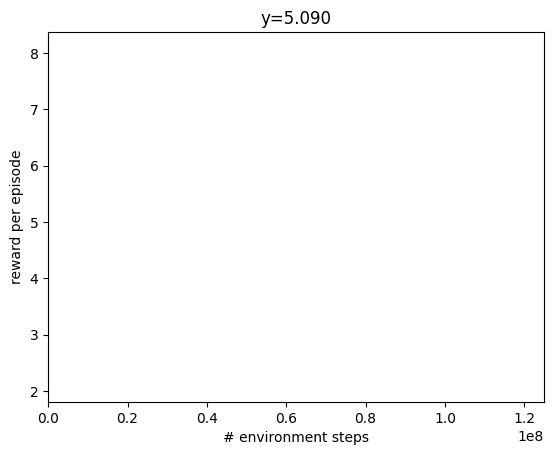

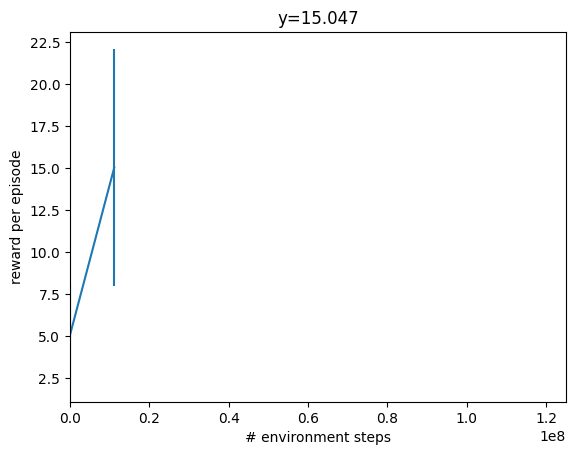

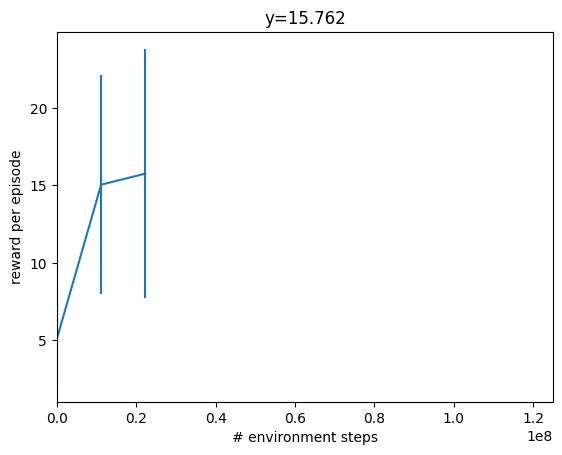

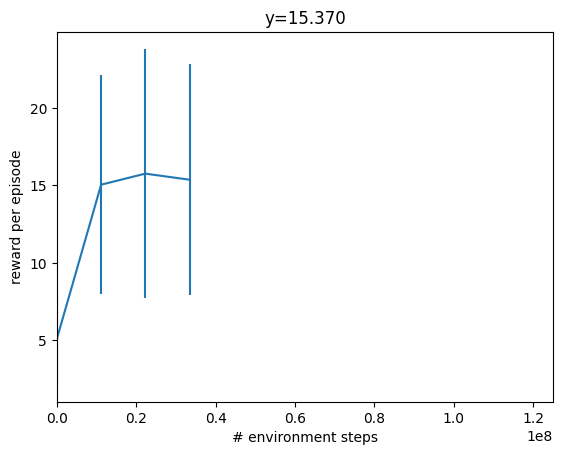

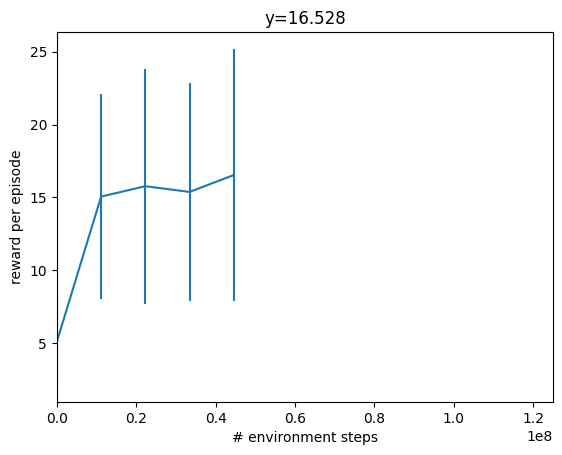

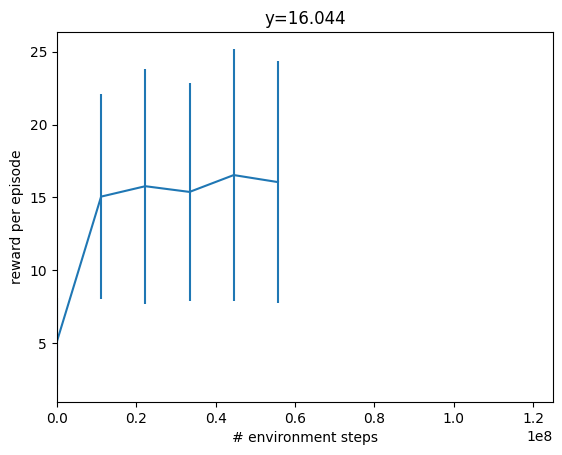

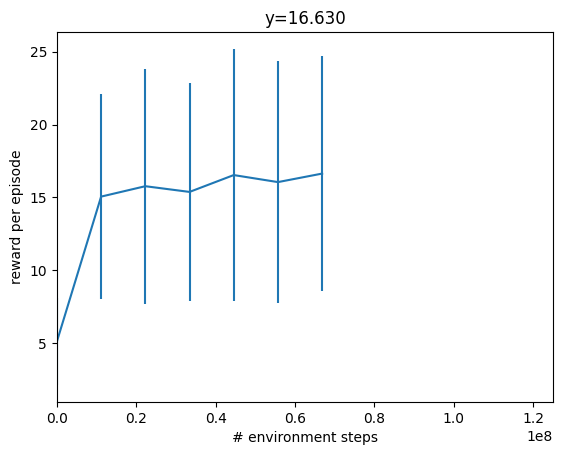

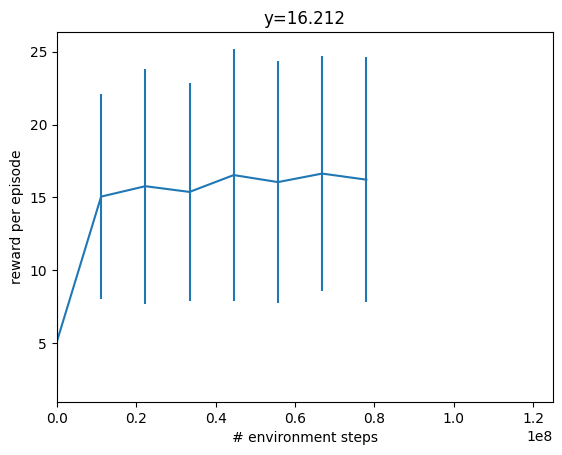

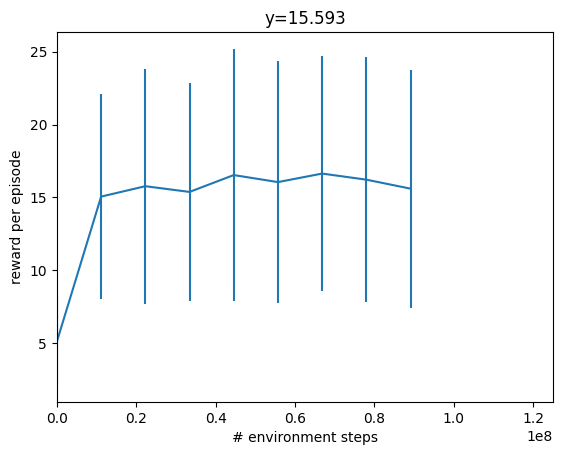

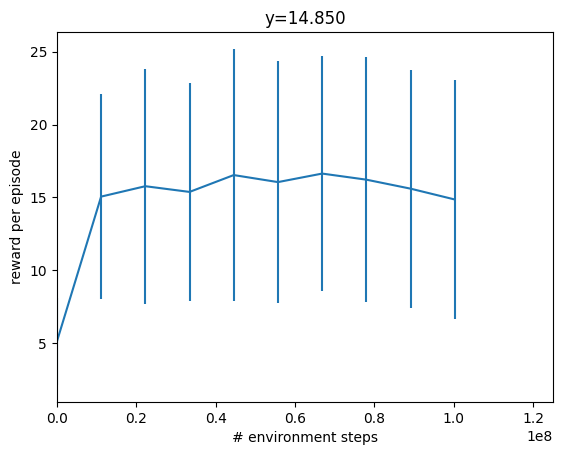

time to jit: 0:00:33.909400
time to train: 1:25:49.091791


In [4]:
make_networks_factory = functools.partial(
    ppo_networks.make_ppo_networks, policy_hidden_layer_sizes=(512, 256, 128)
)

train_fn = functools.partial(
    ppo.train,
    num_timesteps=100_000_000,
    num_evals=10,
    reward_scaling=1.0,
    episode_length=1000,
    normalize_observations=True,
    action_repeat=1,
    unroll_length=20,
    num_minibatches=32,
    num_updates_per_batch=4,
    discounting=0.97,
    learning_rate=3e-4,
    entropy_cost=1e-2,
    num_envs=1024,
    batch_size=256,
    seed=0,
    network_factory=make_networks_factory,
    # randomization_fn=domain_randomize,
)


x_data = []
y_data = []
ydataerr = []
times = [datetime.now()]

max_y, min_y = 13000, 0


def progress(num_steps, metrics):
    times.append(datetime.now())
    x_data.append(num_steps)
    y_data.append(metrics["eval/episode_reward"])
    ydataerr.append(metrics["eval/episode_reward_std"])

    plt.xlim([0, train_fn.keywords["num_timesteps"] * 1.25])
    # plt.ylim([min_y, max_y])

    plt.xlabel("# environment steps")
    plt.ylabel("reward per episode")
    plt.title(f"y={y_data[-1]:.3f}")

    plt.errorbar(x_data, y_data, yerr=ydataerr)
    plt.show()


make_inference_fn, params, _ = train_fn(environment=env, progress_fn=progress)

print(f"time to jit: {times[1] - times[0]}")
print(f"time to train: {times[-1] - times[1]}")

In [5]:
# @title Save Model
model_path = "/home/wenli/MPPI-RL/mppi_rl/tmp/mjx_brax_policy/h1_policy1"
model.save_params(model_path, params)

In [6]:
# @title Load Model and Define Inference Function
# model_path = '/home/wenli/MPPI-RL/mppi_rl/tmp/mjx_brax_policy/go2_policy3'
params = model.load_params(model_path)

inference_fn = make_inference_fn(params)
jit_inference_fn = jax.jit(inference_fn)

In [7]:
# eval_env = UnitreeGo2EnvRL(config)
# eval_env = UnitreeGo2EnvRL()
eval_env = UnitreeH1EnvRL()

jit_reset = jax.jit(eval_env.reset)
jit_step = jax.jit(eval_env.step)

In [8]:
# initialize the state
rng = jax.random.PRNGKey(0)
state = jit_reset(rng)
rollout = [state.pipeline_state]

# grab a trajectory
n_steps = 1000
render_every = 1

for i in range(n_steps):
    act_rng, rng = jax.random.split(rng)
    ctrl, _ = jit_inference_fn(state.obs, act_rng)
    state = jit_step(state, ctrl)
    rollout.append(state.pipeline_state)
    print(state.done)
    print(state.info["command"])
    if state.done:
        break

media.show_video(
    env.render(
        rollout[::render_every],
    ),
    fps=1.0 / env.dt / render_every,
)

0.0
[ 0.262 -0.286 -0.216]
0.0
[ 0.262 -0.286 -0.216]
0.0
[ 0.262 -0.286 -0.216]
0.0
[ 0.262 -0.286 -0.216]
0.0
[ 0.262 -0.286 -0.216]
0.0
[ 0.262 -0.286 -0.216]
0.0
[ 0.262 -0.286 -0.216]
0.0
[ 0.262 -0.286 -0.216]
0.0
[ 0.262 -0.286 -0.216]
0.0
[ 0.262 -0.286 -0.216]
0.0
[ 0.262 -0.286 -0.216]
0.0
[ 0.262 -0.286 -0.216]
0.0
[ 0.262 -0.286 -0.216]
0.0
[ 0.262 -0.286 -0.216]
0.0
[ 0.262 -0.286 -0.216]
0.0
[ 0.262 -0.286 -0.216]
0.0
[ 0.262 -0.286 -0.216]
0.0
[ 0.262 -0.286 -0.216]
0.0
[ 0.262 -0.286 -0.216]
0.0
[ 0.262 -0.286 -0.216]
0.0
[ 0.262 -0.286 -0.216]
0.0
[ 0.262 -0.286 -0.216]
1.0
[ 0.262 -0.286 -0.216]


ValueError: The camera "track" does not exist.

In [235]:
# @title Barkour vb Quadruped Env

GO2_ROOT_PATH = epath.Path("mujoco_menagerie/unitree_go2")


def get_config():
    """Returns reward config for barkour quadruped environment."""

    def get_default_rewards_config():
        default_config = config_dict.ConfigDict(
            dict(
                # The coefficients for all reward terms used for training. All
                # physical quantities are in SI units, if no otherwise specified,
                # i.e. joint positions are in rad, positions are measured in meters,
                # torques in Nm, and time in seconds, and forces in Newtons.
                scales=config_dict.ConfigDict(
                    dict(
                        # Tracking rewards are computed using exp(-delta^2/sigma)
                        # sigma can be a hyperparameters to tune.
                        # Track the base x-y velocity (no z-velocity tracking.)
                        tracking_lin_vel=1.5,
                        # Track the angular velocity along z-axis, i.e. yaw rate.
                        tracking_ang_vel=0.8,
                        # Below are regularization terms, we roughly divide the
                        # terms to base state regularizations, joint
                        # regularizations, and other behavior regularizations.
                        # Penalize the base velocity in z direction, L2 penalty.
                        lin_vel_z=-2.0,
                        # Penalize the base roll and pitch rate. L2 penalty.
                        ang_vel_xy=-0.05,
                        # Penalize non-zero roll and pitch angles. L2 penalty.
                        orientation=-5.0,
                        # L2 regularization of joint torques, |tau|^2.
                        torques=-0.0002,
                        # Penalize the change in the action and encourage smooth
                        # actions. L2 regularization |action - last_action|^2
                        action_rate=-0.01,
                        # Encourage long swing steps.  However, it does not
                        # encourage high clearances.
                        feet_air_time=0.2,
                        # Encourage no motion at zero command, L2 regularization
                        # |q - q_default|^2.
                        stand_still=-0.5,
                        # Early termination penalty.
                        termination=-1.0,
                        # Penalizing foot slipping on the ground.
                        foot_slip=-0.1,
                    )
                ),
                # Tracking reward = exp(-error^2/sigma).
                tracking_sigma=0.25,
            )
        )
        return default_config

    default_config = config_dict.ConfigDict(
        dict(
            rewards=get_default_rewards_config(),
        )
    )

    return default_config


class UnitreeGo2EnvRL(PipelineEnv):
    """Environment for training the barkour quadruped joystick policy in MJX."""

    def __init__(
        self,
        obs_noise: float = 0.05,
        action_scale: float = 0.3,
        kick_vel: float = 0.05,
        scene_file: str = "scene_mjx.xml",
        **kwargs,
    ):
        # path = GO2_ROOT_PATH / scene_file
        # sys = mjcf.load(path.as_posix())
        model_path = get_model_path("unitree_go2", "mjx_scene.xml")
        sys = mjcf.load(model_path)
        self._dt = 0.02  # this environment is 50 fps
        sys = sys.tree_replace({"opt.timestep": 0.02})

        # override menagerie params for smoother policy
        sys = sys.replace(
            dof_damping=sys.dof_damping.at[6:].set(0.5239),
            actuator_gainprm=sys.actuator_gainprm.at[:, 0].set(35.0),
            actuator_biasprm=sys.actuator_biasprm.at[:, 1].set(-35.0),
        )

        n_frames = kwargs.pop("n_frames", int(self._dt / sys.opt.timestep))
        super().__init__(sys, backend="mjx", n_frames=n_frames)

        self.reward_config = get_config()
        # set custom from kwargs
        for k, v in kwargs.items():
            if k.endswith("_scale"):
                self.reward_config.rewards.scales[k[:-6]] = v

        self._torso_idx = mujoco.mj_name2id(
            sys.mj_model, mujoco.mjtObj.mjOBJ_BODY.value, "torso"
        )
        self._action_scale = action_scale
        self._obs_noise = obs_noise
        self._kick_vel = kick_vel
        self._init_q = jp.array(sys.mj_model.keyframe("home").qpos)
        self._default_pose = sys.mj_model.keyframe("home").qpos[7:]
        # self.lowers = jp.array([-0.8, -1.2, -2.5] * 4)
        # self.uppers = jp.array([0.8, 2.3, -0.6] * 4)
        self.lowers = jp.array([-0.5, 0.4, -2.3] * 4)
        self.uppers = jp.array([0.5, 1.4, -1.3] * 4)
        feet_site = [
            "FL_foot",
            "FR_foot",
            "RL_foot",
            "RR_foot",
        ]
        feet_site_id = [
            mujoco.mj_name2id(sys.mj_model, mujoco.mjtObj.mjOBJ_SITE.value, f)
            for f in feet_site
        ]
        assert not any(id_ == -1 for id_ in feet_site_id), "Site not found."
        self._feet_site_id = np.array(feet_site_id)
        lower_leg_body = [
            "FL_calf",
            "FR_calf",
            "RL_calf",
            "RR_calf",
        ]
        lower_leg_body_id = [
            mujoco.mj_name2id(sys.mj_model, mujoco.mjtObj.mjOBJ_BODY.value, l)
            for l in lower_leg_body
        ]
        assert not any(id_ == -1 for id_ in lower_leg_body_id), "Body not found."
        self._lower_leg_body_id = np.array(lower_leg_body_id)
        self._foot_radius = 0.0175
        self._nv = sys.nv

    def make_system(self, config: UnitreeGo2EnvConfig) -> System:
        model_path = get_model_path("unitree_go2", "mjx_scene.xml")
        sys = mjcf.load(model_path)
        sys = sys.tree_replace({"opt.timestep": config.timestep})
        return sys

    def sample_command(self, rng: jax.Array) -> jax.Array:
        lin_vel_x = [-0.6, 1.5]  # min max [m/s]
        lin_vel_y = [-0.8, 0.8]  # min max [m/s]
        ang_vel_yaw = [-0.7, 0.7]  # min max [rad/s]

        _, key1, key2, key3 = jax.random.split(rng, 4)
        lin_vel_x = jax.random.uniform(
            key1, (1,), minval=lin_vel_x[0], maxval=lin_vel_x[1]
        )
        lin_vel_y = jax.random.uniform(
            key2, (1,), minval=lin_vel_y[0], maxval=lin_vel_y[1]
        )
        ang_vel_yaw = jax.random.uniform(
            key3, (1,), minval=ang_vel_yaw[0], maxval=ang_vel_yaw[1]
        )
        new_cmd = jp.array([lin_vel_x[0], lin_vel_y[0], ang_vel_yaw[0]])
        return new_cmd

    def reset(self, rng: jax.Array) -> State:  # pytype: disable=signature-mismatch
        rng, key = jax.random.split(rng)

        pipeline_state = self.pipeline_init(self._init_q, jp.zeros(self._nv))

        state_info = {
            "rng": rng,
            "last_act": jp.zeros(12),
            "last_vel": jp.zeros(12),
            "command": self.sample_command(key),
            "last_contact": jp.zeros(4, dtype=bool),
            "feet_air_time": jp.zeros(4),
            "rewards": {k: 0.0 for k in self.reward_config.rewards.scales.keys()},
            "kick": jp.array([0.0, 0.0]),
            "step": 0,
        }

        obs_history = jp.zeros(15 * 31)  # store 15 steps of history
        obs = self._get_obs(pipeline_state, state_info, obs_history)
        reward, done = jp.zeros(2)
        metrics = {"total_dist": 0.0}
        for k in state_info["rewards"]:
            metrics[k] = state_info["rewards"][k]
        state = State(
            pipeline_state, obs, reward, done, metrics, state_info
        )  # pytype: disable=wrong-arg-types
        return state

    def step(
        self, state: State, action: jax.Array
    ) -> State:  # pytype: disable=signature-mismatch
        rng, cmd_rng, kick_noise_2 = jax.random.split(state.info["rng"], 3)

        # kick
        push_interval = 10
        kick_theta = jax.random.uniform(kick_noise_2, maxval=2 * jp.pi)
        kick = jp.array([jp.cos(kick_theta), jp.sin(kick_theta)])
        kick *= jp.mod(state.info["step"], push_interval) == 0
        qvel = state.pipeline_state.qvel  # pytype: disable=attribute-error
        qvel = qvel.at[:2].set(kick * self._kick_vel + qvel[:2])
        state = state.tree_replace({"pipeline_state.qvel": qvel})

        # physics step
        motor_targets = self._default_pose + action * self._action_scale
        motor_targets = jp.clip(motor_targets, self.lowers, self.uppers)
        pipeline_state = self.pipeline_step(state.pipeline_state, motor_targets)
        x, xd = pipeline_state.x, pipeline_state.xd

        # observation data
        obs = self._get_obs(pipeline_state, state.info, state.obs)
        joint_angles = pipeline_state.q[7:]
        joint_vel = pipeline_state.qd[6:]

        # foot contact data based on z-position
        foot_pos = pipeline_state.site_xpos[
            self._feet_site_id
        ]  # pytype: disable=attribute-error
        foot_contact_z = foot_pos[:, 2] - self._foot_radius
        contact = foot_contact_z < 1e-3  # a mm or less off the floor
        contact_filt_mm = contact | state.info["last_contact"]
        contact_filt_cm = (foot_contact_z < 3e-2) | state.info["last_contact"]
        first_contact = (state.info["feet_air_time"] > 0) * contact_filt_mm
        state.info["feet_air_time"] += self.dt

        # done if joint limits are reached or robot is falling
        up = jp.array([0.0, 0.0, 1.0])
        done = jp.dot(math.rotate(up, x.rot[self._torso_idx - 1]), up) < 0
        done |= jp.any(joint_angles < self.lowers)
        done |= jp.any(joint_angles > self.uppers)
        done |= pipeline_state.x.pos[self._torso_idx - 1, 2] < 0.18

        # reward
        rewards = {
            "tracking_lin_vel": (
                self._reward_tracking_lin_vel(state.info["command"], x, xd)
            ),
            "tracking_ang_vel": (
                self._reward_tracking_ang_vel(state.info["command"], x, xd)
            ),
            "lin_vel_z": self._reward_lin_vel_z(xd),
            "ang_vel_xy": self._reward_ang_vel_xy(xd),
            "orientation": self._reward_orientation(x),
            "torques": self._reward_torques(
                pipeline_state.qfrc_actuator
            ),  # pytype: disable=attribute-error
            "action_rate": self._reward_action_rate(action, state.info["last_act"]),
            "stand_still": self._reward_stand_still(
                state.info["command"],
                joint_angles,
            ),
            "feet_air_time": self._reward_feet_air_time(
                state.info["feet_air_time"],
                first_contact,
                state.info["command"],
            ),
            "foot_slip": self._reward_foot_slip(pipeline_state, contact_filt_cm),
            "termination": self._reward_termination(done, state.info["step"]),
        }
        rewards = {
            k: v * self.reward_config.rewards.scales[k] for k, v in rewards.items()
        }
        reward = jp.clip(sum(rewards.values()) * self.dt, 0.0, 10000.0)

        # state management
        state.info["kick"] = kick
        state.info["last_act"] = action
        state.info["last_vel"] = joint_vel
        state.info["feet_air_time"] *= ~contact_filt_mm
        state.info["last_contact"] = contact
        state.info["rewards"] = rewards
        state.info["step"] += 1
        state.info["rng"] = rng

        # sample new command if more than 500 timesteps achieved
        state.info["command"] = jp.where(
            state.info["step"] > 500,
            self.sample_command(cmd_rng),
            state.info["command"],
        )
        # reset the step counter when done
        state.info["step"] = jp.where(
            done | (state.info["step"] > 500), 0, state.info["step"]
        )

        # log total displacement as a proxy metric
        state.metrics["total_dist"] = math.normalize(x.pos[self._torso_idx - 1])[1]
        state.metrics.update(state.info["rewards"])

        done = jp.float32(done)
        state = state.replace(
            pipeline_state=pipeline_state, obs=obs, reward=reward, done=done
        )
        return state

    def _get_obs(
        self,
        pipeline_state: base.State,
        state_info: dict[str, Any],
        obs_history: jax.Array,
    ) -> jax.Array:
        inv_torso_rot = math.quat_inv(pipeline_state.x.rot[0])
        local_rpyrate = math.rotate(pipeline_state.xd.ang[0], inv_torso_rot)

        obs = jp.concatenate(
            [
                jp.array([local_rpyrate[2]]) * 0.25,  # yaw rate
                math.rotate(jp.array([0, 0, -1]), inv_torso_rot),  # projected gravity
                state_info["command"] * jp.array([2.0, 2.0, 0.25]),  # command
                pipeline_state.q[7:] - self._default_pose,  # motor angles
                state_info["last_act"],  # last action
            ]
        )

        # clip, noise
        obs = jp.clip(obs, -100.0, 100.0) + self._obs_noise * jax.random.uniform(
            state_info["rng"], obs.shape, minval=-1, maxval=1
        )
        # stack observations through time
        obs = jp.roll(obs_history, obs.size).at[: obs.size].set(obs)

        return obs

    # ------------ reward functions----------------
    def _reward_lin_vel_z(self, xd: Motion) -> jax.Array:
        # Penalize z axis base linear velocity
        return jp.square(xd.vel[0, 2])

    def _reward_ang_vel_xy(self, xd: Motion) -> jax.Array:
        # Penalize xy axes base angular velocity
        return jp.sum(jp.square(xd.ang[0, :2]))

    def _reward_orientation(self, x: Transform) -> jax.Array:
        # Penalize non flat base orientation
        up = jp.array([0.0, 0.0, 1.0])
        rot_up = math.rotate(up, x.rot[0])
        return jp.sum(jp.square(rot_up[:2]))

    def _reward_torques(self, torques: jax.Array) -> jax.Array:
        # Penalize torques
        return jp.sqrt(jp.sum(jp.square(torques))) + jp.sum(jp.abs(torques))

    def _reward_action_rate(self, act: jax.Array, last_act: jax.Array) -> jax.Array:
        # Penalize changes in actions
        return jp.sum(jp.square(act - last_act))

    def _reward_tracking_lin_vel(
        self, commands: jax.Array, x: Transform, xd: Motion
    ) -> jax.Array:
        # Tracking of linear velocity commands (xy axes)
        local_vel = math.rotate(xd.vel[0], math.quat_inv(x.rot[0]))
        lin_vel_error = jp.sum(jp.square(commands[:2] - local_vel[:2]))
        lin_vel_reward = jp.exp(
            -lin_vel_error / self.reward_config.rewards.tracking_sigma
        )
        return lin_vel_reward

    def _reward_tracking_ang_vel(
        self, commands: jax.Array, x: Transform, xd: Motion
    ) -> jax.Array:
        # Tracking of angular velocity commands (yaw)
        base_ang_vel = math.rotate(xd.ang[0], math.quat_inv(x.rot[0]))
        ang_vel_error = jp.square(commands[2] - base_ang_vel[2])
        return jp.exp(-ang_vel_error / self.reward_config.rewards.tracking_sigma)

    def _reward_feet_air_time(
        self, air_time: jax.Array, first_contact: jax.Array, commands: jax.Array
    ) -> jax.Array:
        # Reward air time.
        rew_air_time = jp.sum((air_time - 0.1) * first_contact)
        rew_air_time *= (
            math.normalize(commands[:2])[1] > 0.05
        )  # no reward for zero command
        return rew_air_time

    def _reward_stand_still(
        self,
        commands: jax.Array,
        joint_angles: jax.Array,
    ) -> jax.Array:
        # Penalize motion at zero commands
        return jp.sum(jp.abs(joint_angles - self._default_pose)) * (
            math.normalize(commands[:2])[1] < 0.1
        )

    def _reward_foot_slip(
        self, pipeline_state: base.State, contact_filt: jax.Array
    ) -> jax.Array:
        # get velocities at feet which are offset from lower legs
        # pytype: disable=attribute-error
        pos = pipeline_state.site_xpos[self._feet_site_id]  # feet position
        feet_offset = pos - pipeline_state.xpos[self._lower_leg_body_id]
        # pytype: enable=attribute-error
        offset = base.Transform.create(pos=feet_offset)
        foot_indices = self._lower_leg_body_id - 1  # we got rid of the world body
        foot_vel = offset.vmap().do(pipeline_state.xd.take(foot_indices)).vel

        # Penalize large feet velocity for feet that are in contact with the ground.
        return jp.sum(jp.square(foot_vel[:, :2]) * contact_filt.reshape((-1, 1)))

    def _reward_termination(self, done: jax.Array, step: jax.Array) -> jax.Array:
        return done & (step < 500)

    def render(
        self,
        trajectory: List[base.State],
        camera: str | None = None,
        width: int = 240,
        height: int = 320,
    ) -> Sequence[np.ndarray]:
        camera = camera or "track"
        return super().render(trajectory, camera=camera, width=width, height=height)